In [90]:
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from src.eval_tools import *

In [91]:
save_dir = "plots/latency/"
dir_name = "join_20250301_PI5"

locations = {
    "join": "experiments/{0}/".format(dir_name),
    #"sliding [1m, 50ms]": "datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc",
    #"tumbling [1s]": "datasets/NES/201123/1sec_100_20_3w_oc",
    #"tumbling [1m]": "datasets/NES/201123/1min_100_20_3w_oc"
}

eval_dir = "experiments/{0}/".format(dir_name)
measurements = {
    "no_stress": {
        "sink-based": "sink_based/join_source_default.out",
        "cluster-based\ntop-c": "cluster/join_source_cluster.out",
        "nova": "nova/join_source_nova.out",
        "source-based\ntree": "tree/join_source_tree.out",
    },
    "stress": {
        "sink-based": "sink_based_stressed/join_source_default.out",
        "cluster-based\ntop-c": "cluster_stressed/join_source_cluster.out",
        "nova": "nova_stressed/join_source_nova.out",
        "source-based\ntree": "tree_stressed/join_source_tree.out",
    }
}

approach_order = [
    "sink-based",
    "cluster-based\ntop-c",
    "source-based\ntree",
    "nova",
]

In [92]:
color_list = sns.color_palette(n_colors=10)
color_dict = {}
for i, k in enumerate(approach_order):
    color_dict[k] = color_list[i]
color_list

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## Read Measurements

In [93]:
# latency_cols = ["start", "end", "id", "start_ts", "arrival"]
latency_cols = ["start", "end", "left_sensorId", "left_location", "left_timestamp", "left_temperature",
                "right_sensorId", "right_location", "right_timestamp", "right_humidity", "arrival"]

ref_col = "start_ts"

latency_results = {}

for experiment, loc in locations.items():
    print(experiment)
    experiment_metrics = {
        "arrival": {},
        "latencies": {},
        "90th percentile": {},
        "99th percentile": {}
    }

    for approach in approach_order:
        for stress_label in measurements.keys():
            path = loc + measurements[stress_label][approach]
            if stress_label.startswith("stress"):
                label = approach + " stress"
            else:
                label = approach

            print(approach, path)
            df = pd.read_csv(path, skiprows=1, names=latency_cols)

            # normalize timestamps
            df["arrival_norm"] = df["arrival"] - df["arrival"].min()
            df['latency'] = df["arrival_norm"].diff().fillna(0)

            df = df[df["latency"] > 0]
            # print(df[df["latency"] <= 0]["latency"].count())

            latencies = df["latency"].to_list()
            experiment_metrics["arrival"][label] = df["arrival_norm"].to_list()
            experiment_metrics["latencies"][label] = latencies
            experiment_metrics["90th percentile"][label] = np.percentile(latencies, 90)
            experiment_metrics["99th percentile"][label] = np.percentile(latencies, 99)
    latency_results[experiment] = experiment_metrics

join
sink-based experiments/join_20250301_PI5/sink_based/join_source_default.out
sink-based experiments/join_20250301_PI5/sink_based_stressed/join_source_default.out
cluster-based
top-c experiments/join_20250301_PI5/cluster/join_source_cluster.out
cluster-based
top-c experiments/join_20250301_PI5/cluster_stressed/join_source_cluster.out
source-based
tree experiments/join_20250301_PI5/tree/join_source_tree.out
source-based
tree experiments/join_20250301_PI5/tree_stressed/join_source_tree.out
nova experiments/join_20250301_PI5/nova/join_source_nova.out
nova experiments/join_20250301_PI5/nova_stressed/join_source_nova.out


In [94]:
df

,start,end,left_sensorId,left_location,left_timestamp,left_temperature,right_sensorId,right_location,right_timestamp,right_humidity,arrival,arrival_norm,latency
1,2,3,29791,16693,2,13.74,65817,16693,2,57.89,1740841476895,2,2.0
2,1,2,29791,16693,1,13.75,65817,16693,1,57.68,1740841476899,6,4.0
3,3,4,29791,16693,3,13.74,65817,16693,3,57.61,1740841476900,7,1.0
4,2,3,29791,16693,2,13.74,65817,16693,2,57.89,1740841476903,10,3.0
5,3,4,29791,16693,3,13.74,65817,16693,3,57.61,1740841476906,13,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8980,3223,3224,29791,16693,3223,13.48,65817,16693,3223,56.20,1740841598849,121956,92.0
8981,1115,1116,29791,16693,1115,18.09,65817,16693,1115,37.84,1740841598945,122052,96.0
8982,3224,3225,29791,16693,3224,13.47,65817,16693,3224,55.89,1740841599014,122121,69.0
8983,3225,3226,29791,16693,3225,13.46,65817,16693,3225,55.62,1740841599123,122230,109.0


In [95]:
latency_results.keys()

dict_keys(['join'])

In [96]:
latency_results[list(latency_results.keys())[0]].keys()

dict_keys(['arrival', 'latencies', '90th percentile', '99th percentile'])

In [97]:
latency_results[list(latency_results.keys())[0]]["latencies"].keys()

dict_keys(['sink-based', 'sink-based stress', 'cluster-based\ntop-c', 'cluster-based\ntop-c stress', 'source-based\ntree', 'source-based\ntree stress', 'nova', 'nova stress'])

In [98]:
experiment = "join"
latency_vals = latency_results[experiment]["latencies"]
time_vals = latency_results[experiment]["arrival"]

In [99]:
latency_results

{'join': {'arrival': {'sink-based': [19,
    37,
    61,
    87,
    108,
    130,
    148,
    171,
    189,
    211,
    238,
    255,
    283,
    304,
    326,
    346,
    372,
    392,
    417,
    445,
    463,
    490,
    514,
    535,
    548,
    569,
    591,
    614,
    635,
    674,
    697,
    718,
    764,
    783,
    822,
    846,
    871,
    911,
    931,
    952,
    973,
    1021,
    1042,
    1061,
    1107,
    1127,
    1154,
    1173,
    1217,
    1241,
    1288,
    1310,
    1333,
    1379,
    1400,
    1418,
    1471,
    1492,
    1517,
    1565,
    1592,
    1618,
    1639,
    1690,
    1715,
    1764,
    1791,
    1819,
    1839,
    1891,
    1912,
    1938,
    1998,
    2017,
    2071,
    2091,
    2120,
    2174,
    2200,
    2222,
    2249,
    2301,
    2328,
    2354,
    2406,
    2431,
    2457,
    2509,
    2536,
    2569,
    2598,
    2649,
    2677,
    2729,
    2757,
    2793,
    2828,
    2860,
    2904,
    2972,
    3009,
  

## Scatter Plot

In [100]:
latency_vals.keys()

dict_keys(['sink-based', 'sink-based stress', 'cluster-based\ntop-c', 'cluster-based\ntop-c stress', 'source-based\ntree', 'source-based\ntree stress', 'nova', 'nova stress'])

In [101]:
approach_order = get_approaches()
eval_colors = get_eval_colors_dict()
markers = get_markers_dict()
styles = get_styles_dict()

sink-based 1057
sink-based stress 546
cluster-based
top-c 1503
cluster-based
top-c stress 230
source-based
tree 3176
source-based
tree stress 2211
nova 14159
nova stress 8805


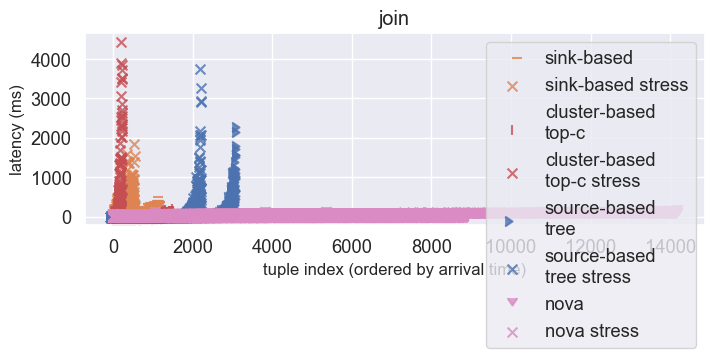

In [102]:
# Create a figure and axes for the box plots
fig, ax = plt.subplots(figsize=(8, 2.5))
min_ns = sys.maxsize
min_s = sys.maxsize

i = 1
for k in latency_vals.keys():
    norm_ts = time_vals[k]
    v = latency_vals[k]
    print(k, len(v))
    if "stress" in k:
        marker = "x"
        if len(v) < min_s:
            min_s = len(v)
    else:
        marker = i #str(i)
        if len(v) < min_ns:
            min_ns = len(v)

    if k == "matrix":
        zorder = 10
    else:
        zorder = 1

    c_label = k.replace(" stress", "").split("\n")[0]
    if c_label in eval_colors:
        color = eval_colors[c_label]
    elif c_label == "cluster-based":
        color = eval_colors["cl-sf"]
    else:
        color = color_dict[i]

    ax.scatter([i for i in range(len(v))], v, label=k, s=50, alpha=0.8, marker=marker,
               color=color, zorder=zorder)
    #ax.scatter(norm_ts, v, label=k, s=50, alpha=0.8, marker=marker,
    #           color=color_dict[k.replace(" stress", "")], zorder=zorder)
    i = i + 1

# set the axis labels and title
plt.xlabel("tuple index (ordered by arrival time)", fontsize=12)
plt.ylabel('latency (ms)', fontsize=12)

# Set the legend
plt.legend(loc="upper right") #, bbox_to_anchor=(1, 1.04))

plt.savefig(save_dir + "latency_scatter.svg", bbox_inches="tight")

# show the plot
plt.title(experiment)

plt.show()

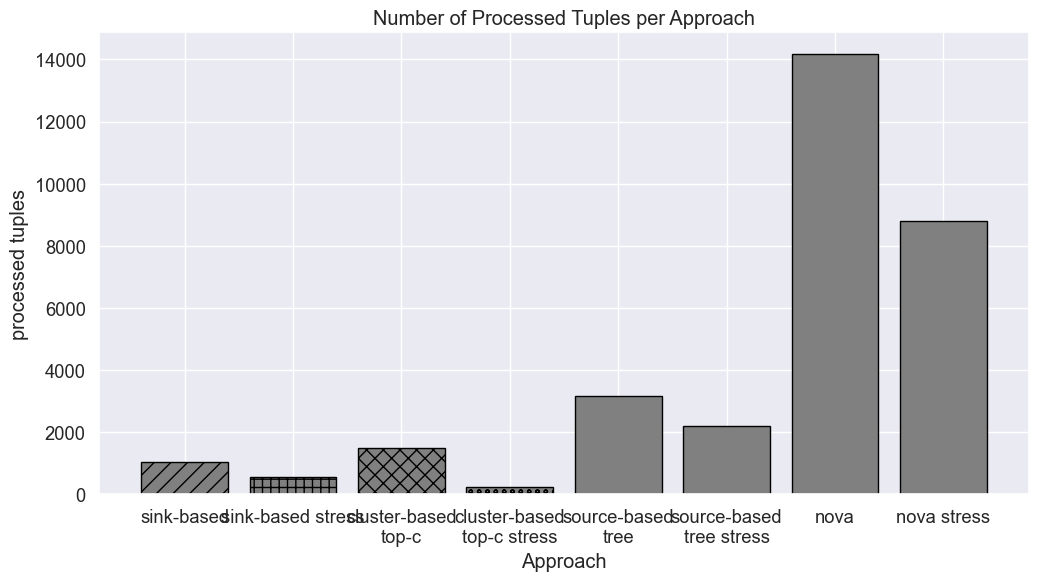

In [103]:
# Create a figure and axes for the box plots
fig, ax = plt.subplots(figsize=(12, 6))

approaches = latency_vals.keys()
counts = [len(v) for v in latency_vals.values()]

hatches = {
    "sink-based": "//",  # Triple diagonal lines
    "source-based": "++",  # Triple plus signs
    "tree": "xx",  # Triple 'x' marks
    "nova": "oo",  # Triple circles
    # "chain": "///+++xxx"  # Combination of patterns
}

# Create the bar plot
bars = ax.bar(approaches, counts, color="grey", edgecolor="black")

# Apply hatching to each bar
for bar, hatch in zip(bars, hatches.values()):
    bar.set_hatch(hatch)

# Labels and title
ax.set_xlabel("Approach")
ax.set_ylabel("processed tuples")
ax.set_title("Number of Processed Tuples per Approach")

# Show the plot
plt.show()


## Box plots

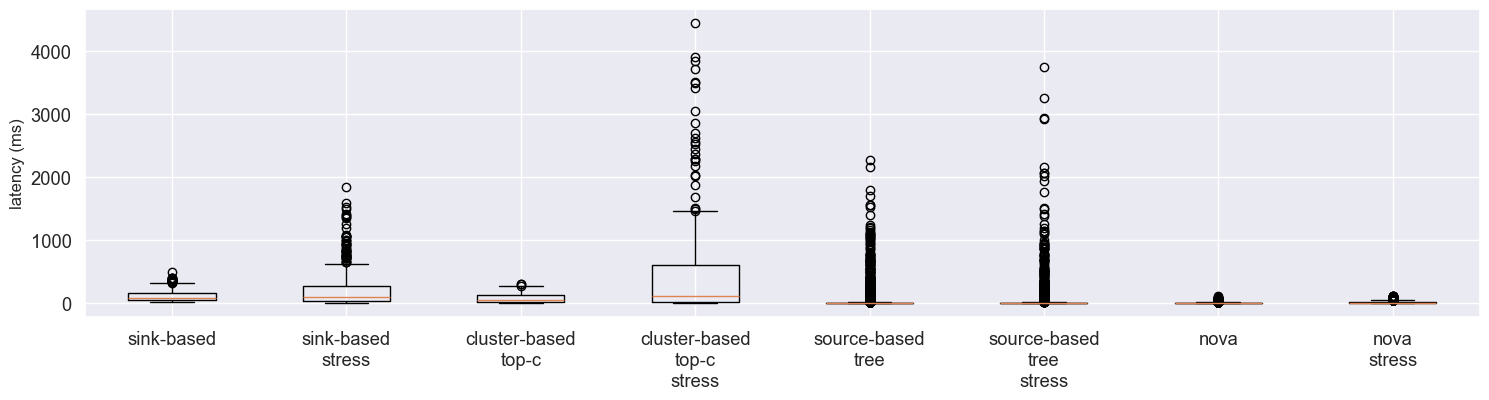

In [104]:
# Create a figure and axes for the box plots
fig, ax = plt.subplots(figsize=(18, 4))

plot_latencies = {}
for k, v in latency_vals.items():
    plot_latencies[k] = v
    #if not k.startswith("top-down"):
    #    plot_latencies[k] = v

# Extract the keys and values from the measurements dictionary
labels = plot_latencies.keys()
values = plot_latencies.values()

# Create the box plots for each key-value pair
ax.boxplot(values)

# Format x-tick labels with line breaks for the second word after a space
formatted_labels = [label.replace(' ', '\n', 1) for label in labels]
ax.set_xticklabels(formatted_labels)

# Set the title
plt.ylabel('latency (ms)', fontsize=12)

plt.savefig(save_dir + "latency_boxplot_no_td.svg", bbox_inches="tight")

# Display the plot
# plt.title("Latency (wait_time={0}ms)".format(waitTime))
plt.show()

## Scatter Quantiles

In [111]:
percentiles = ["mean", 90, 95, 99, 99.99]
approaches = []
values = []
perc_label = []

for k, v in latency_vals.items():
    #if "top-down" in k:
    #    continue
    for pval in percentiles:
        if pval == "mean":
            perc = np.mean(v)
        else:
            perc = np.percentile(v, pval).round(2)
        approaches.append(k)
        values.append(perc)
        perc_label.append(pval)

df_dict = dict(approach=approaches, value=values, percentile=perc_label)
df = pd.DataFrame(df_dict)

In [112]:
df

,approach,value,percentile
0,sink-based,115.335856,mean
1,sink-based,230.000000,90
2,sink-based,266.200000,95
3,sink-based,361.440000,99
4,sink-based,481.020000,99.99
5,sink-based stress,223.307692,mean
6,sink-based stress,613.500000,90
7,sink-based stress,860.250000,95
8,sink-based stress,1388.250000,99
9,sink-based stress,1827.700000,99.99


ValueError: Unrecognized marker style '5'

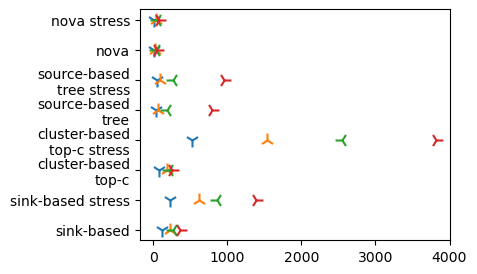

In [115]:
# Create the dot plot using matplotlib
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(4, 3))
color_list = sns.color_palette(n_colors=len(percentiles))
i = 0
for perc in percentiles:
    mask = df["percentile"] == perc
    ax.scatter(df.loc[mask, "value"], df.loc[mask, "approach"], color=color_list[i], label=str(perc), marker=str(i + 1),
               s=100)
    i = i + 1

ax.set_xlabel("Latency (ms)")
ax.legend(title="Percentile", bbox_to_anchor=(1.04, 1), loc="upper left")
ax.grid(axis='y')

plt.savefig(save_dir + "latency_percentile_scatter.svg", bbox_inches='tight')
plt.show()

## Heatmap Quantiles

In [116]:
value_dict = {}

for k, v in latency_vals.items():
    values = []
    for pval in percentiles:
        if pval == "mean":
            perc = np.mean(v)
        else:
            perc = np.percentile(v, pval).round(2)
        values.append(perc)
    value_dict[k] = values

df = pd.DataFrame.from_dict(value_dict, columns=percentiles, orient='index').astype(int)
df

,mean,90,95,99,99.99
sink-based,115,230,266,361,481
sink-based stress,223,613,860,1388,1827
cluster-based\ntop-c,80,187,213,258,310
cluster-based\ntop-c stress,520,1531,2547,3812,4433
source-based\ntree,37,61,184,790,2240
source-based\ntree stress,54,97,269,951,3643
nova,8,23,33,55,91
nova stress,13,38,53,77,113


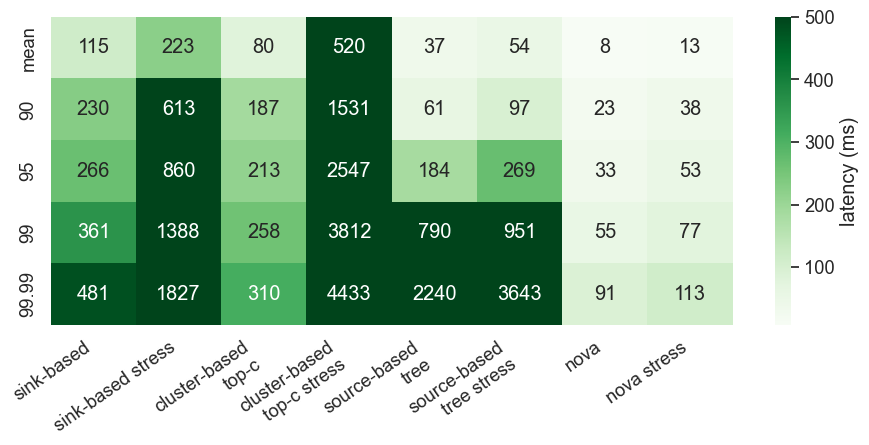

In [122]:
# Transpose the DataFrame
df_transposed = df.T

# Create the heatmap
fig, ax = plt.subplots(figsize=(11, 4))
sns.set_theme(font_scale=1.2)

sns.heatmap(df_transposed, annot=True, cmap='Greens', vmax=500, cbar_kws={'label': 'latency (ms)'}, cbar=True, fmt='.0f', ax=ax)

# Rotate xtick labels (if needed)
plt.xticks(rotation=35, ha='right')

# Update axis labels
#plt.xlabel("Categories")  # Adjust based on your data
#plt.ylabel("Percentiles")  # Adjust based on your data

# Save and display
plt.savefig(save_dir + "latency_heatmap_perc.svg", bbox_inches='tight')
plt.show()

## 90th Percentiles All Experiments

In [21]:
latency_results.keys()

dict_keys(['join'])

In [22]:
rows = []

for experiment in latency_results.keys():
    for approach, val in latency_results[experiment]['99th percentile'].items():
        #if approach.startswith("top-down"):  # and experiment.startswith("sliding"):
        #    continue
        row = {"experiment": experiment, "approach": approach, "value": val}
        rows.append(row)
df = pd.DataFrame(rows)

In [52]:
df

,experiment,approach,value
0,join,sink-based,361.44
1,join,sink-based stress,1388.25
2,join,cluster,258.96
3,join,cluster stress,3812.04
4,join,tree,790.00
5,join,tree stress,951.50
6,join,nova,55.00
7,join,nova stress,77.00


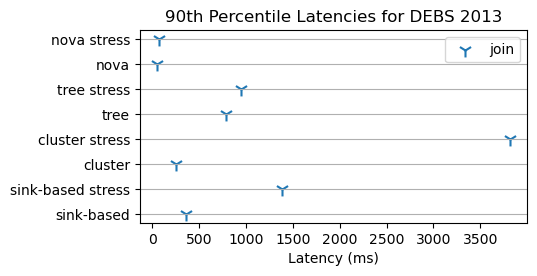

In [53]:
# Create the dot plot using matplotlib
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(5, 2.5))
color_list = sns.color_palette(n_colors=len(percentiles))
i = 0
for experiment in latency_results.keys():
    mask = df["experiment"] == experiment
    ax.scatter(df.loc[mask, "value"], df.loc[mask, "approach"], color=color_list[i], label=str(experiment),
               marker=str(i + 1),
               s=100)
    i = i + 1

ax.set_xlabel("Latency (ms)")
ax.legend()
ax.grid(axis='y')

plt.savefig(save_dir + "latency_90th_all_no_td.svg", bbox_inches='tight')

plt.title("90th Percentile Latencies for DEBS 2013")
plt.show()

## Box plots all experiments

In [213]:
latency_results.keys()

dict_keys(['join'])

In [214]:
rows = []

for experiment in latency_results.keys():
    for approach, values in latency_results[experiment]['latencies'].items():
        # if approach.startswith("top-down"): # and experiment.startswith("sliding"):
        #    continue
        for val in values:
            row = {"experiment": experiment, "approach": approach, "value": val}
            rows.append(row)
df = pd.DataFrame(rows)

In [215]:
df

,experiment,approach,value
0,join,sink-based,17.0
1,join,sink-based,21.0
2,join,sink-based,27.0
3,join,sink-based,20.0
4,join,sink-based,28.0
...,...,...,...
41162,join,nova stress,53.0
41163,join,nova stress,21.0
41164,join,nova stress,115.0
41165,join,nova stress,113.0


In [216]:
# quantiles

df.groupby(['approach'])['value'].quantile(0.9)

approach
nova                    30.0
nova stress             39.0
sink-based             218.0
sink-based stress      218.7
source-based            51.5
source-based stress     41.0
tree                    51.0
tree stress             47.0
Name: value, dtype: float64

In [222]:
dff = df[
    df["approach"].isin(["sink-based", "source-based", "tree", "nova"])]
grouped_df = dff.groupby(['approach'])['value'].agg(list)
grouped_df

approach
nova            [3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, ...
sink-based      [17.0, 21.0, 27.0, 20.0, 28.0, 13.0, 11.0, 39....
source-based    [2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
tree            [3.0, 3.0, 3.0, 3.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...
Name: value, dtype: object

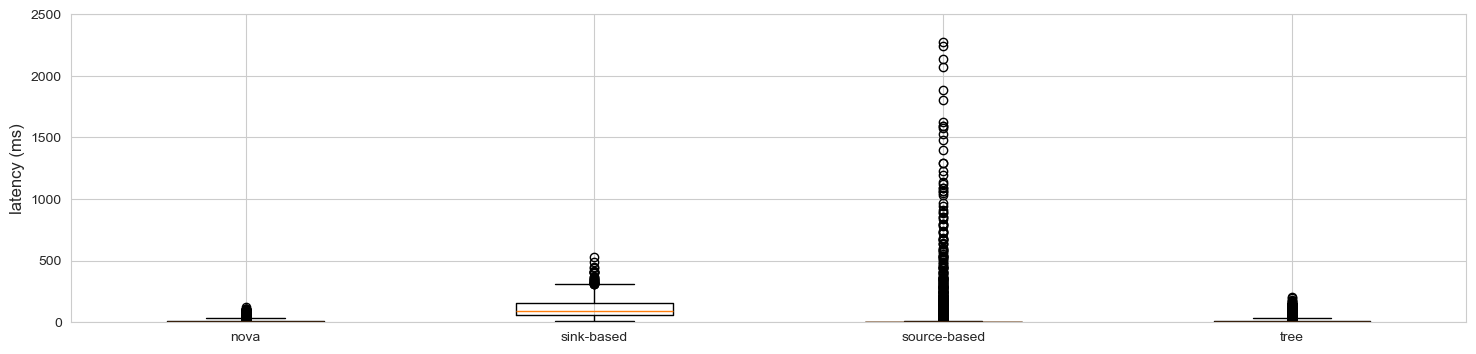

In [223]:
# Create a figure and axes for the box plots
fig, ax = plt.subplots(figsize=(18, 4))

plot_latencies = grouped_df.to_dict()
# del plot_latencies["top-down"]
# del plot_latencies["top-down stress"]

# Extract the keys and values from the measurements dictionary
labels = plot_latencies.keys()
values = plot_latencies.values()

# Create the box plots for each key-value pair
ax.boxplot(values)

# Format x-tick labels with line breaks for the second word after a space
formatted_labels = [label.replace(' stress', '\n', 1) for label in labels]
ax.set_xticklabels(formatted_labels)

# Set the title
plt.ylabel('latency (ms)', fontsize=12)
plt.ylim([0, 2500])

plt.savefig(save_dir + "latency_boxplot_all_no_td.svg", bbox_inches='tight')

# Display the plot
# plt.title("Latency (wait_time={0}ms)".format(waitTime))
plt.show()

ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of labels (8).

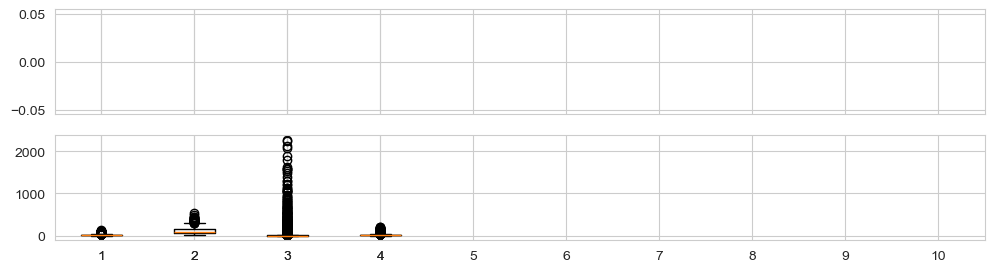

In [219]:
# Create a figure with two subplots
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 3), sharex=True)

plot_latencies = grouped_df.to_dict()

# Extract the keys and values from the measurements dictionary
labels = plot_latencies.keys()
values = list(plot_latencies.values())
v2 = [[]] * 10 + list(values)[10:]

# Create the box plots for each key-value pair
ax1.boxplot(v2)
ax2.boxplot(values)

# Format x-tick labels with line breaks for the second word after a space
formatted_labels = [label.replace(' ', '\n', 1) for label in labels]
ax1.set_xticklabels(formatted_labels + formatted_labels)

# Set the title
ax2.set_ylim([0, 2500])
ax1.set_ylim([2000, 125000])

# remove the y-labels
ax2.set_ylabel('latency (ms)', fontsize=12)
ax2.yaxis.set_label_coords(-0.06, 1.08)

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.savefig(save_dir + "latency_boxplot_all.svg", bbox_inches='tight')

plt.show()